## Shadow Removal Code 

by Yalım Doğan

This software is implemented according to the methods presented in:

- Murali, Saritha, and V. K. Govindan. 
"Removal of shadows from a single image." 
the Proceedings of First International Conference on Futuristic Trends 
in Computer Science and Engineering. Vol. 4.

- Murali, Saritha, and V. K. Govindan. 
"Shadow detection and removal from a single image using LAB color space." 
Cybernetics and information technologies 13.1 (2013): 95-103.

In [22]:
import cv2 as cv
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt

from typing import Tuple, List
import pandas as pd

In [23]:
# Applies median filtering over given point
def median_filter(img: np.ndarray,
                  point: np.ndarray,
                  filter_size: int) -> List:
    indices = [[x, y]
               for x in range(point[1] - filter_size // 2, point[1] + filter_size // 2 + 1)
               for y in range(point[0] - filter_size // 2, point[0] + filter_size // 2 + 1)]

    indices = list(filter(lambda x: not (x[0] < 0 or x[1] < 0 or
                                         x[0] >= img.shape[0] or
                                         x[1] >= img.shape[1]), indices))

    pixel_values = [0, 0, 0]

    # Find the median of pixel values
    for channel in range(3):
        pixel_values[channel] = list(img[index[0], index[1], channel] for index in indices)
    pixel_values = list(np.median(pixel_values, axis=1))

    return pixel_values


# Applies median filtering on given contour pixels, the filter size is adjustable
def edge_median_filter(img: np.ndarray,
                       contours_list: tuple,
                       filter_size: int = 7) -> np.ndarray:
    temp_img = np.copy(img)

    for partition in contours_list:
        for point in partition:
            temp_img[point[0][1]][point[0][0]] = median_filter(img,
                                                               point[0],
                                                               filter_size)

    return cv.cvtColor(temp_img, cv.COLOR_HSV2BGR)

In [24]:
def display_region(org_image: np.ndarray,
                   shadow_clear_image: np.ndarray,
                   label: int,
                   label_region: np.ndarray,
                   contours: tuple) -> None:
    # For debugging, cut the current shadow region from the image
    reverse_mask = cv.cvtColor(cv.bitwise_not(label_region), cv.COLOR_GRAY2BGR)
    img_w_hole = org_image & reverse_mask

    temp_filter = cv.cvtColor(label_region, cv.COLOR_GRAY2BGR)
    cv.drawContours(temp_filter, contours, -1, (255, 0, 0), 3)

    fig, axes = plt.subplots(2, 2)

    ax = axes.ravel()

    plt.title(f"Shadow Region {label}")

    ax[0].imshow(cv.cvtColor(org_image, cv.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")

    ax[1].imshow(cv.cvtColor(temp_filter, cv.COLOR_BGR2RGB))
    ax[1].set_title("Shadow Region")

    ax[2].imshow(cv.cvtColor(img_w_hole, cv.COLOR_BGR2RGB))
    ax[2].set_title("Shadow Region Cut")

    ax[3].imshow(cv.cvtColor(shadow_clear_image, cv.COLOR_BGR2RGB))
    ax[3].set_title("Corrected Image")

    plt.tight_layout()
    plt.show()

In [25]:
def correct_region_lab(org_img: np.ndarray,
                       shadow_clear_img: np.ndarray,
                       shadow_indices: np.ndarray,
                       non_shadow_indices: np.ndarray) -> np.ndarray:
    # Q: Rather than asking for RGB constants individually, why not adjust L only?
    # A: L component isn't enough to REVIVE the colors that were under the shadow.

    # Calculate average LAB values in current shadow region and non-shadow areas
    shadow_average_lab = np.mean(org_img[shadow_indices[0], shadow_indices[1], :], axis=0)

    # Get the average LAB from border areas
    border_average_lab = np.mean(org_img[non_shadow_indices[0], non_shadow_indices[1], :],
                                 axis=0)

    # Calculate ratios that are going to be used on clearing the current shadow region
    # This is different for each region, therefore calculated each time
    lab_ratio = border_average_lab / shadow_average_lab

    shadow_clear_img = cv.cvtColor(shadow_clear_img, cv.COLOR_BGR2LAB)
    shadow_clear_img[shadow_indices[0], shadow_indices[1]] = np.uint8(
        shadow_clear_img[shadow_indices[0],
                         shadow_indices[1]] * lab_ratio)
    shadow_clear_img = cv.cvtColor(shadow_clear_img, cv.COLOR_LAB2BGR)

    return shadow_clear_img


def correct_region_bgr(org_img: np.ndarray,
                       shadow_clear_img: np.ndarray,
                       shadow_indices: np.ndarray,
                       non_shadow_indices: np.ndarray) -> np.ndarray:
    # Calculate average BGR values in current shadow region and non-shadow areas
    shadow_average_bgr = np.mean(org_img[shadow_indices[0], shadow_indices[1], :], axis=0)

    # Get the average BGR from border areas
    border_average_bgr = np.mean(org_img[non_shadow_indices[0], non_shadow_indices[1], :], axis=0)
    bgr_ratio = border_average_bgr / shadow_average_bgr

    # Adjust BGR
    shadow_clear_img[shadow_indices[0], shadow_indices[1]] = np.uint8(
        shadow_clear_img[shadow_indices[0],
                         shadow_indices[1]] * bgr_ratio)

    return shadow_clear_img

In [26]:
def process_regions(org_image: np.ndarray,
                    mask: np.ndarray,
                    lab_adjustment: bool,
                    shadow_dilation_kernel_size: int,
                    shadow_dilation_iteration: int,
                    shadow_size_threshold: int,
                    verbose: bool) -> np.ndarray:
    lab_img = cv.cvtColor(org_image, cv.COLOR_BGR2LAB)
    shadow_clear_img = np.copy(org_image)  # Used for constructing corrected image

    # We need connected components
    # Initialize the labels of the blobs in our binary image
    labels = measure.label(mask)

    non_shadow_kernel_size = (shadow_dilation_kernel_size, shadow_dilation_kernel_size)
    non_shadow_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, non_shadow_kernel_size)

    CHANNEL_MAX = 255

    # Now, we will iterate over each label's pixels
    for label in np.unique(labels):
        if not label == 0:
            temp_filter = np.zeros(mask.shape, dtype="uint8")
            temp_filter[labels == label] = CHANNEL_MAX

            # Only consider blobs with size above threshold
            if cv.countNonZero(temp_filter) >= shadow_size_threshold:
                shadow_indices = np.where(temp_filter == CHANNEL_MAX)

                non_shadow_temp_filter = cv.dilate(temp_filter, non_shadow_kernel,
                                                   iterations=shadow_dilation_iteration)

                # Get the new set of indices and remove shadow indices from them
                non_shadow_temp_filter = cv.bitwise_xor(non_shadow_temp_filter, temp_filter)
                non_shadow_indices = np.where(non_shadow_temp_filter == CHANNEL_MAX)

                # Contours are used for extracting the edges of the current shadow region
                contours, hierarchy = cv.findContours(temp_filter, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

                if lab_adjustment:
                    shadow_clear_img = correct_region_lab(lab_img, shadow_clear_img,
                                                          shadow_indices, non_shadow_indices)
                else:
                    shadow_clear_img = correct_region_bgr(org_image, shadow_clear_img,
                                                          shadow_indices, non_shadow_indices)

                # Then apply median filtering over edges to smooth them
                # At least on the images I tried, this doesn't work as intended.
                # It is possible that this is the result of using a high frequency image only

                # Image is converted to HSV before filtering, as BGR components of the image
                # is more interconnected, therefore filtering each channel independently wouldn't be correct
                shadow_clear_img = edge_median_filter(cv.cvtColor(shadow_clear_img, cv.COLOR_BGR2HSV),
                                                      contours)
                if verbose:
                    display_region(org_image, shadow_clear_img, label, temp_filter, contours)

    return shadow_clear_img

In [27]:
def calculate_mask(org_image: np.ndarray,
                   ab_threshold: int,
                   region_adjustment_kernel_size: int) -> np.ndarray:
    lab_img = cv.cvtColor(org_image, cv.COLOR_BGR2LAB)

    # Convert the L,A,B from 0 to 255 to 0 - 100 and -128 - 127 and -128 - 127 respectively
    l_range = (0, 100)
    ab_range = (-128, 127)

    lab_img = lab_img.astype('int16')
    lab_img[:, :, 0] = lab_img[:, :, 0] * l_range[1] / 255
    lab_img[:, :, 1] += ab_range[0]
    lab_img[:, :, 2] += ab_range[0]

    # Calculate the mean values of L, A and B across all pixels
    means = [np.mean(lab_img[:, :, i]) for i in range(3)]
    thresholds = [means[i] - (np.std(lab_img[:, :, i]) / 3) for i in range(3)]

    # Apply threshold using only L
    if sum(means[1:]) <= ab_threshold:
        mask = cv.inRange(lab_img, (l_range[0], ab_range[0], ab_range[0]),
                                   (thresholds[0], ab_range[1], ab_range[1]))
    else:  # Else, also consider B channel
        mask = cv.inRange(lab_img, (l_range[0], ab_range[0], ab_range[0]),
                                   (thresholds[0], ab_range[1], thresholds[2]))

    kernel_size = (region_adjustment_kernel_size, region_adjustment_kernel_size)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, kernel_size)
    cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, mask)
    cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, mask)

    return mask

In [28]:
def remove_shadows(org_image: np.ndarray,
                   ab_threshold: int,
                   lab_adjustment: bool,
                   region_adjustment_kernel_size: int,
                   shadow_dilation_iteration: int,
                   shadow_dilation_kernel_size: int,
                   shadow_size_threshold: int,
                   verbose: bool) -> Tuple[np.ndarray, np.ndarray]:
    mask = calculate_mask(org_image,
                          ab_threshold,
                          region_adjustment_kernel_size)

    shadow_clear_img = process_regions(org_image,
                                       mask,
                                       lab_adjustment,
                                       shadow_dilation_kernel_size,
                                       shadow_dilation_iteration,
                                       shadow_size_threshold,
                                       verbose)

    mask = cv.cvtColor(mask, cv.COLOR_GRAY2RGB)

    return shadow_clear_img, mask

In [29]:
def process_image_file(org_image,
                       ab_threshold: int = 256,
                       lab_adjustment: bool = False,
                       region_adjustment_kernel_size: int = 10,
                       shadow_dilation_kernel_size: int = 5,
                       shadow_dilation_iteration: int = 3,
                       shadow_size_threshold: int = 2500,
                       verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    shadow_clear, mask = remove_shadows(org_image,
                                        ab_threshold,
                                        lab_adjustment,
                                        region_adjustment_kernel_size,
                                        shadow_dilation_iteration,
                                        shadow_dilation_kernel_size,
                                        shadow_size_threshold,
                                        verbose=verbose)

    _, axes = plt.subplots(1, 3)
    ax = axes.ravel()

    plt.title("Final Results")

    ax[0].imshow(cv.cvtColor(org_image, cv.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")

    ax[1].imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
    ax[1].set_title("Shadow Regions")

    ax[2].imshow(cv.cvtColor(shadow_clear, cv.COLOR_BGR2RGB))
    ax[2].set_title("Corrected Image")

    plt.tight_layout()
    plt.show()
    return org_image, mask, shadow_clear

In [30]:
path = "C:/SWdacon/minseo/data/"
csv_file = path+'train.csv'
train_img_path = path+'train_img/'

In [31]:
csv = pd.read_csv(csv_file)

In [21]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [43]:
img_num = 64

In [46]:
mask_rle = csv.iloc[img_num, 2]
image_path = csv.iloc[img_num, 1]
image = cv.imread(path+ image_path[2:])
mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
x,y=200,400
image = image[y:y+224,x:x+224]
mask = mask[y:y+224,x:x+224]

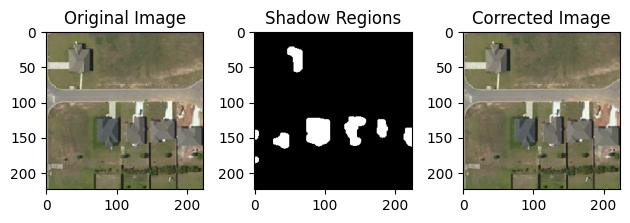

In [47]:
org_image, mask, image_clear = process_image_file(image, ab_threshold = 0,  verbose = True)